<div>
    <img src="https://storage.googleapis.com/kaggle-datasets-images/1095652/1842717/81b3e916b94ca50abf884397c5641711/dataset-cover.jpeg" />
</div>

In [ ]:
import numpy as np
import pandas as pd

import IPython
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

<h1 id="dataset" style="color:#ffb802; background:#071d35; border:0.5px dotted #ffb802;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [ ]:
base_path = '../input/binance-top-cryptocurrencies/'
df_xlm = pd.read_csv(base_path + 'XLM.csv')['open']
df_xlm = pd.DataFrame({'open' : df_xlm.values})

train_df, test_df = train_test_split(df_xlm, test_size=0.3, random_state=42)
val_df = pd.read_csv(base_path + 'ADA.csv')['open']
val_df = pd.DataFrame({'open' : val_df.values})

<h1 id="window" style="color:#ffb802; background:#071d35; border:0.5px dotted #ffb802;"> 
    <center>Window Generator
        <a class="anchor-link" href="#window" target="_self">¶</a>
    </center>
</h1>

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

<h1 id="window" style="color:#ffb802; background:#071d35; border:0.5px dotted #ffb802;"> 
    <center>Window Generator Datasets
        <a class="anchor-link" href="#window" target="_self">¶</a>
    </center>
</h1>

In [ ]:
class WindowGenerator(WindowGenerator):
    def __init__(self, input_width, label_width, shift,
               label_columns=None):
        super().__init__(input_width, label_width, shift,
               label_columns=label_columns)

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

<h1 id="window" style="color:#ffb802; background:#071d35; border:0.5px dotted #ffb802;"> 
    <center>Window Generator Plot
        <a class="anchor-link" href="#window" target="_self">¶</a>
    </center>
</h1>

In [ ]:
class WindowGenerator(WindowGenerator):
    def __init__(self, input_width, label_width, shift,
               label_columns=None):
        super().__init__(input_width, label_width, shift,
               label_columns=label_columns)
        
    def plot(self, model=None, plot_col='open', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')

In [ ]:
num_features = 1
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

<h1 id="autoregressive" style="color:#ffb802; background:#071d35; border:0.5px dotted #ffb802;"> 
    <center>Autoregressive
        <a class="anchor-link" href="#autoregressive" target="_self">¶</a>
    </center>
</h1>

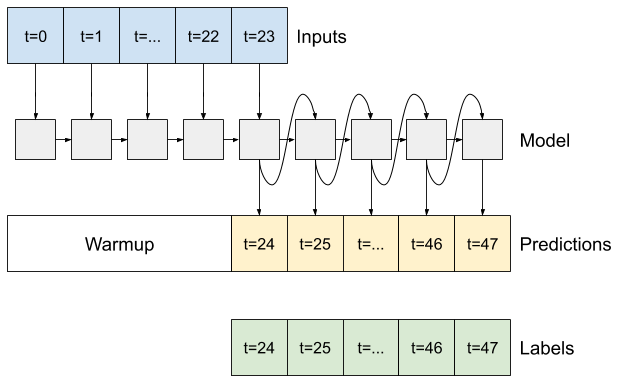

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
print(prediction.shape)

<h1 id="train" style="color:#ffb802; background:#071d35; border:0.5px dotted #ffb802;"> 
    <center>Training
        <a class="anchor-link" href="#train" target="_self">¶</a>
    </center>
</h1>

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

eval_val = feedback_model.evaluate(multi_window.val)
eval_test = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

<h1 id="reference" style="color:#ffb802; background:#071d35; border:0.5px dotted #ffb802;"> 
    <center>Reference
        <a class="anchor-link" href="#reference" target="_self">¶</a>
    </center>
</h1>

Tensorflow [Time Series Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)